# Image classification from file system

In the previous training lab we created a tensorflow dataset using 

```python
from_tensor_slices()
```

But now we are interested in another scenario. What if we have the classified images in different directories (this is, we a system folder for classA images, another for classB images, and so on).

Tensorflow allows us to create objects that will fetch this images in bunddles (batches) and load them to the model on demand. Hence, we won't have to load the whole set of images (potentially overloading the system memory) at once, but instead we may choose to gradually fetch them.

There's an extra added bonus feature for these types of objects : **preprocessing** is natively supported in by tensorflow, meaning that we can load and prepare the iamges at once. Also, it allows us to add a  **data-augmentation** process just as easily, providing us with a potential solution for overfitting problems (adressing bias).



## Downloading an appropriate dataset

I'm going to use a [kaggle](https://www.kaggle.com/) dataset here.

In order to do so in google colab, we have to follow the steps showcased [here](https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a) or [here](https://colab.research.google.com/drive/1I7UN_1PljB3go4lugJrVEOLP86LnioS7?usp=sharing).

The code cells below aren't an exact replica of the guides, but my own take on it ...

### 1. Mounting drive directory

Let's mount the google drive directory - so we can access a personal key to use kaggle, and download the dataset we will be working with.

*Note* :  This will only work if you have a folder with the kaggle.json token pre-setup (see the guides linked above to do so)

In [1]:
import os
import pathlib
import zipfile

from google.colab import drive


The cell below will prompt a message asking for access permisions to the drive of an account (the google account running the colab instance)

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### 2. The `kaggle.json` key

Now, to download the dataset we will have to add an enviromental variable linked to the drive directory that contains the kaggle.json key

In my case, I called that directory in drive /kaggle

In [3]:
KAGGLE_KEY_PATH = "/content/gdrive/My Drive/kaggle"
os.environ['KAGGLE_CONFIG_DIR'] = KAGGLE_KEY_PATH

### 3. Locating and downloading the dataset

I want the intel-image-classification dataset - let's see if we can locate is by listing datasets in kaggle with similar keywords

In [4]:
!kaggle datasets list -s intel-image-classification

ref                                                             title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
puneet6060/intel-image-classification                           Intel Image Classification                        346MB  2019-01-30 09:22:58          79198       1321  0.75             
kkhandekar/image-dataset                                        Image_Dataset                                     171MB  2020-06-28 22:44:13            910         27  0.8125           
utkarshsaxenadn/intel-image-classifier-resblockcustom-model     Intel Image Classifier - ResBlock(Custom Model)   279KB  2022-10-02 02:48:22             10          8  1.0              
kutaykutlu/drowsiness-detection                                 Drowsi

In [5]:
PATH_TO_DOWNLOAD = pathlib.Path('.').absolute() / "gdrive/My Drive/kaggle"

assert PATH_TO_DOWNLOAD.is_dir(), "\nUnable to locate the path provided or no-path provided"

print(str(PATH_TO_DOWNLOAD))

/content/gdrive/My Drive/kaggle


We can copy the path above to provide a path where the files will be downloaded (I prefer to download them in my drive, so I only have to do this once)

In [6]:
'/'.join(str(PATH_TO_DOWNLOAD).split('/')[2:])

'gdrive/My Drive/kaggle'

Now, notice that since I have an space in the path (My Drive), I have to add a backslash so the path can be correctly read by the kaggle API download command.

Also, the path is given with respect to the current working directory - which is the content\/ directory for the google colab (*thus, the modification to the string done above*)

In [7]:
!kaggle datasets download -d puneet6060/intel-image-classification -p gdrive/My\ Drive/kaggle

 97% 337M/346M [00:05<00:00, 52.5MB/s]
100% 346M/346M [00:05<00:00, 62.2MB/s]


### 4. Extracting files

We have downloaded the zipfile - let's unzip it and delete the .zip

1. The initial idea was to unzip the file in drive ... but this would cause a real problem with the model training - basically, creating a dataset that reads batchs of images - hosting the machine in colab and fetching data from drive - is painfully slow

2. So, the solution is to save the zip in drive, and unzip it to the local colab enviroment created.

3. This has a clear drawback though - each time we restart the runtime, the files are gone ... so we are going to lose some time in unziping, but gain a lot in training.


In [8]:
os.listdir(PATH_TO_DOWNLOAD)

['kaggle.json', 'intel-image-classification.zip']

The downloaded file is `'intel-image-classification.zip'`

In [11]:
# This cell may take a while to complete - 
# it's going to unzip the whole file sequentially ...

if 'images' not in os.listdir(os.getcwd()):
  os.mkdir('images')

path_to_zip = PATH_TO_DOWNLOAD / "intel-image-classification.zip"
path_to_unzip = pathlib.Path('.').absolute() / 'images'

print('Begining the unzip process')
with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
    zip_ref.extractall(path_to_unzip)

print('Finished the unzipping')

Begining the unzip process
Finished the unzipping


Let's inspect the folders created

In [12]:
print('Testing files')
print('*'*80,'\n')
print(f"Total # testing files : {len(os.listdir(path_to_unzip / 'seg_pred' / 'seg_pred'))}")

Testing files
******************************************************************************** 

Total # testing files : 7301


In [13]:
count = 0
print('Validation (dev) files')
print('*'*80,'\n')
for subdir in os.listdir(path_to_unzip  / 'seg_test' / 'seg_test'):
  length = len(os.listdir(path_to_unzip  / 'seg_test' / 'seg_test' / subdir))
  print(subdir , ' # files : ' , length)
  count += length
print('_'*80)
print(f'Total # validation (dev) files : {count}')

Validation (dev) files
******************************************************************************** 

mountain  # files :  525
forest  # files :  474
glacier  # files :  553
buildings  # files :  437
sea  # files :  510
street  # files :  501
________________________________________________________________________________
Total # validation (dev) files : 3000


In [14]:
count = 0
print('Training files')
print('*'*80,'\n')
for subdir in os.listdir(path_to_unzip  / 'seg_train' / 'seg_train'):
  length = len(os.listdir(path_to_unzip  / 'seg_train' / 'seg_train' / subdir))
  print(subdir , ' # files : ' , length)
  count += length
print('_'*80)
print(f'Total # train files : {count}')

Training files
******************************************************************************** 

mountain  # files :  2512
forest  # files :  2271
glacier  # files :  2404
buildings  # files :  2191
sea  # files :  2274
street  # files :  2382
________________________________________________________________________________
Total # train files : 14034


We are not going to delete the zipfile

1.  On the one hand, it would free some memory space

2. But, we want to keep the zip file in drive so we do not have to download it again from kaggle

## Tensorflow - Creating the dataset object

In [82]:
import pathlib
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [83]:
tf.device(tf.test.gpu_device_name())

Let's see some examples of the images we will be using

In [18]:
train_directory = pathlib.Path('.').absolute() / "images/seg_train/seg_train"
print(str(train_directory))

assert train_directory.is_dir(), 'Incorrect training directory provided'

/content/images/seg_train/seg_train


In [19]:
# One image
image = plt.imread(train_directory /'buildings' /os.listdir(train_directory/'buildings')[200])

print(f"Image Shape : {image.shape}")
print(f"RGB Max values : {image.max(axis = (0,1))}")
print(f"RGB min values : {image.min(axis = (0,1))}")



Image Shape : (150, 150, 3)
RGB Max values : [255 255 255]
RGB min values : [0 0 0]


So, we have 150x150 rgb images

We can roll with this, or convert them to grey scale

Im my opinion, the RGB factor may play in out favour here ... as the coloration may give away the type of image we are looking at.

Nonetheless, we still have to rescale the values ...

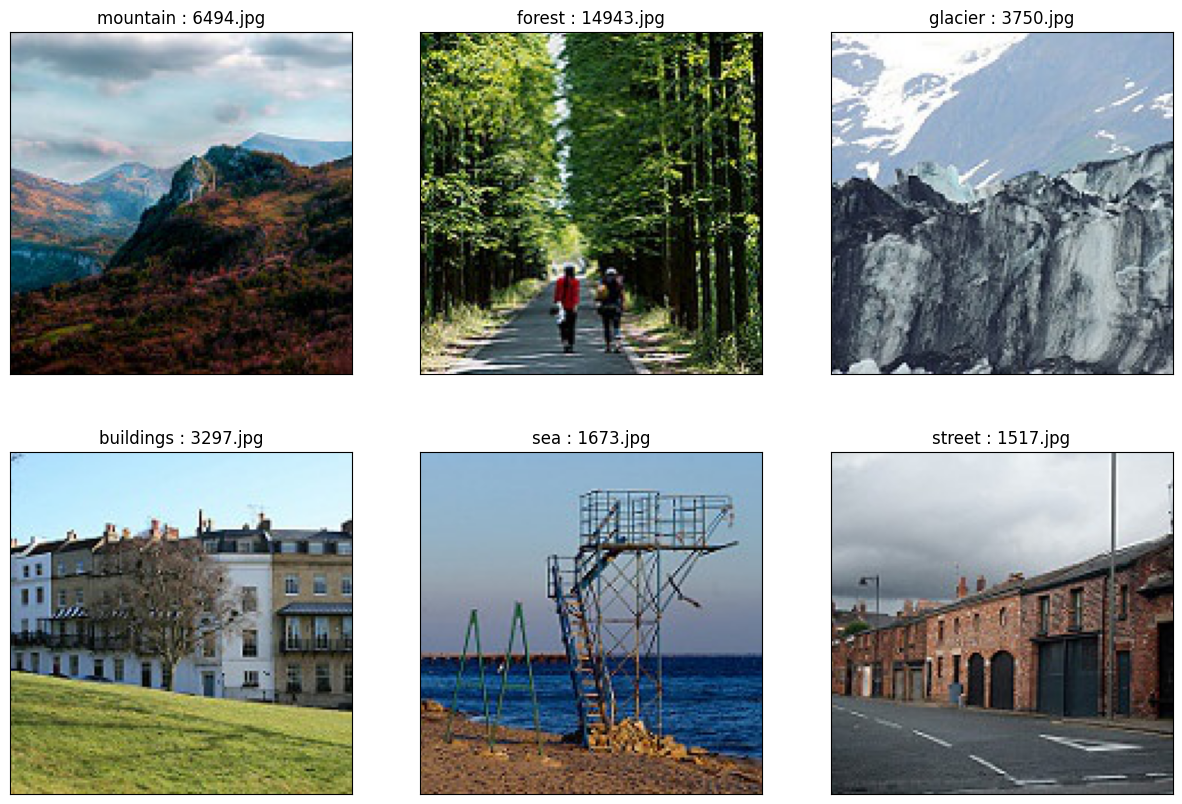

In [20]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (15,10), squeeze = False)

training_folders = os.listdir(train_directory)

for i,ax in enumerate(axes.flatten()):
  ims_names = os.listdir(train_directory / training_folders[i])
  n_im = np.random.randint(0, len(ims_names))
  image = plt.imread(train_directory /training_folders[i] / ims_names[n_im])
  ax.set_title(f'{training_folders[i]} : {ims_names[n_im]}')
  ax.imshow(image)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.close()

fig

Awesome ... although quite a complex dataset.

Let's see if we are able of creating a convolutional network powerful enough to classify it ...

### Deprecated ImageDataGenerator

In this case, we could deal with this type process with the the image-data-generator object - that will take advantage of the directory structure to create the dataset for us.

But we instead may choose to use the newly recomended route to do this - that will allow us to prefetch images, as well as interleave loadings

In [21]:
train_directory

PosixPath('/content/images/seg_train/seg_train')

Old way of dealing with this
```python

tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255.)

train_dataset = datagen.flow_from_directory(
    #directory = '.',
    directory = train_directory,
    target_size = (150,150),
    batch_size= 512,
    class_mode = "categorical" 
)
```

Now

In [22]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory = train_directory,
    image_size = (150,150),
    batch_size = 16,
    label_mode = 'categorical'
)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

Found 14034 files belonging to 6 classes.


### The model

This time, a bit more complex. let's have 3 levels of convolutional layers (conv+maxpool)

In [30]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(16, (5,5), activation = 'relu', input_shape = (150,150,3)),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(32, (5,5), activation = 'relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(64, (5,5), activation = 'relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256,activation = 'relu'),
        tf.keras.layers.Dense(64,activation = 'relu'),
        tf.keras.layers.Dense(6,activation = 'softmax'),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 146, 146, 16)      1216      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 73, 73, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 69, 69, 32)        12832     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 34, 34, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 64)        51264     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 15, 15, 64)      

In [25]:
model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics = ['accuracy']
)

In [26]:
model_h = model.fit(train_dataset, epochs = 5)

Epoch 1/5
878/878 [==============================] - 25s 14ms/step - loss: 1.7435 - accuracy: 0.5341
Epoch 2/5
878/878 [==============================] - 13s 15ms/step - loss: 0.8016 - accuracy: 0.7047
Epoch 3/5
878/878 [==============================] - 12s 13ms/step - loss: 0.6229 - accuracy: 0.7726
Epoch 4/5
878/878 [==============================] - 12s 13ms/step - loss: 0.4934 - accuracy: 0.8206
Epoch 5/5
878/878 [==============================] - 13s 15ms/step - loss: 0.4074 - accuracy: 0.8559


Ok, it's working, and we are improving accuracy in the training process as we go along. 

So, we can move forward

On thing we might have noticed, is that we are not using the GPU memory to it's fullest potential. Let's increase the batch size, so we can fill better the VRAM memory.

In [31]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory = train_directory,
    image_size = (150,150),
    batch_size = 128,
    label_mode = 'categorical'
)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

Found 14034 files belonging to 6 classes.


In [32]:
model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics = ['accuracy']
)
model_h = model.fit(train_dataset, epochs = 5)

Epoch 1/5
110/110 [==============================] - 13s 95ms/step - loss: 6.4060 - accuracy: 0.4538
Epoch 2/5
110/110 [==============================] - 11s 84ms/step - loss: 1.1185 - accuracy: 0.5854
Epoch 3/5
110/110 [==============================] - 11s 96ms/step - loss: 0.9792 - accuracy: 0.6236
Epoch 4/5
110/110 [==============================] - 11s 95ms/step - loss: 0.8601 - accuracy: 0.6731
Epoch 5/5
110/110 [==============================] - 10s 89ms/step - loss: 0.7456 - accuracy: 0.7185


Alright, we are better of this way ... regarding times ...

But we face a critical point here. As the batch size is larger, we are not allowing the model to update weights between batches so often. So the accuracy progress in each epoch is slower. 

Nonetheless, this may become and advantageous point later on, as we may avoid to some extent memorization (overfitting) of the training process.

Let's add a validation set, and try the model as it is for a larger unmber of epochs, to see where we stand.

In [44]:
isinstance(set([1,2,3]), typing.List)

False

In [76]:
import typing
def create_compile_default_model(
    alpha = 0.001,
    beta1 = 0.9, 
    beta2 = 0.999, 
    regularization = None, 
    regularize_fully_connected : bool = False,
    channels : typing.List | None = None,
    include_dropout : bool = False,
    dropout_rate = 0.2,
    include_FC_dropout : bool = False,
    dropout_FC_rate = 0.2):
  
  reg_dense = None
  if isinstance(channels, typing.List):
    c1, c2, c3 = channels
  else:
    c1, c2, c3 = [16,32,64]

  if regularize_fully_connected:
    reg_dense = 'l2'

  
  layers_config = [
        tf.keras.layers.Conv2D(c1, (5,5), activation = 'relu', input_shape = (150,150,3), kernel_regularizer=regularization),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(c2, (5,5), activation = 'relu', kernel_regularizer=regularization),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(c3, (5,5), activation = 'relu', kernel_regularizer=regularization),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256,activation = 'relu', kernel_regularizer= reg_dense),
        tf.keras.layers.Dense(64,activation = 'relu', kernel_regularizer= reg_dense),
        tf.keras.layers.Dense(6,activation = 'softmax'),
    ]

  if include_FC_dropout:
    for id_position in [9,8]:
      layers_config.insert(id_position, tf.keras.layers.Dropout(rate = dropout_FC_rate))

  if include_dropout:
    # We go in reverese, so the indices still make sense
    for id_position in [6,4,2]:
      layers_config.insert(id_position, tf.keras.layers.Dropout(rate = dropout_rate))
  
  model = tf.keras.Sequential(layers_config)
  model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(learning_rate = alpha, beta_1 = beta1, beta_2 = beta2),
      metrics = ['accuracy']
  )
  return model

In [60]:
lista = [1,2,3]

lista.insert(2, 'a')
lista

[1, 2, 'a', 3]

In [46]:
model = create_compile_default_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 146, 146, 16)      1216      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 73, 73, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 69, 69, 32)        12832     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 34, 34, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 30, 30, 64)        51264     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 15, 15, 64)      

In [35]:
test_directory = pathlib.Path('.').absolute() / "images/seg_test/seg_test"
print(str(test_directory))

assert test_directory.is_dir(), 'Incorrect validation directory provided'

/content/images/seg_test/seg_test


In [37]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory = test_directory,
    image_size = (150,150),
    batch_size = 64,
    label_mode = 'categorical'
)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

Found 3000 files belonging to 6 classes.


In [38]:
model_h = model.fit(train_dataset, epochs = 50, validation_data=test_dataset)

Epoch 1/50
110/110 [==============================] - 15s 105ms/step - loss: 5.6930 - accuracy: 0.2191 - val_loss: 1.7878 - val_accuracy: 0.1897
Epoch 2/50
110/110 [==============================] - 12s 109ms/step - loss: 1.6966 - accuracy: 0.2780 - val_loss: 1.4630 - val_accuracy: 0.4477
Epoch 3/50
110/110 [==============================] - 12s 109ms/step - loss: 1.2763 - accuracy: 0.4914 - val_loss: 1.1555 - val_accuracy: 0.5380
Epoch 4/50
110/110 [==============================] - 12s 109ms/step - loss: 1.0441 - accuracy: 0.5760 - val_loss: 1.1039 - val_accuracy: 0.5467
Epoch 5/50
110/110 [==============================] - 12s 109ms/step - loss: 0.9579 - accuracy: 0.6054 - val_loss: 1.1012 - val_accuracy: 0.5680
Epoch 6/50
110/110 [==============================] - 12s 109ms/step - loss: 0.8515 - accuracy: 0.6560 - val_loss: 1.1460 - val_accuracy: 0.5660
Epoch 7/50
110/110 [==============================] - 12s 110ms/step - loss: 0.7622 - accuracy: 0.6885 - val_loss: 1.2751 - val_ac

Ok, clearly, we have a variance problem - we are tending to overfit the training set, while the validation stagnates ... at a quite low accuracy value

In [50]:
def get_plts_from_model(model_h):
  fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20,4.5))
  axes[0].scatter([el +1 for el in model_h.epoch], model_h.history['loss'], c = 'navy', label = 'Train set', marker = 'x')
  axes[0].scatter([el +1 for el in model_h.epoch], model_h.history['val_loss'], c = 'orange', label = 'Validation set')
  axes[0].set_title('Loss evolution')
  axes[0].set_xlabel('Epoch number')
  axes[0].set_ylabel('Loss value')
  axes[0].grid(True)
  axes[0].legend()

  axes[1].scatter([el +1 for el in model_h.epoch], model_h.history['accuracy'], c = 'navy', label = 'Train set', marker = 'x')
  axes[1].scatter([el +1 for el in model_h.epoch], model_h.history['val_accuracy'], c = 'orange', label = 'Validation set')
  axes[1].set_title('Accuracy evolution')
  axes[1].set_xlabel('Epoch number')
  axes[1].set_ylabel('Accuracy value')
  axes[1].grid(True)
  axes[1].legend() 
  plt.close()
  return fig

As a matter of fact, the loss in the validation set is increasing after only a few epochs ...


Let's try some tricks 


1. $L_2$ regularization in the conv layers

In [47]:
model = create_compile_default_model(regularization='l2')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 146, 146, 16)      1216      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 73, 73, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 69, 69, 32)        12832     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 34, 34, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 30, 30, 64)        51264     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 15, 15, 64)      

In [48]:
model_h = model.fit(train_dataset, epochs = 50, validation_data=test_dataset)

Epoch 1/50
110/110 [==============================] - 16s 122ms/step - loss: 9.5173 - accuracy: 0.3398 - val_loss: 1.9006 - val_accuracy: 0.5030
Epoch 2/50
110/110 [==============================] - 13s 107ms/step - loss: 1.6790 - accuracy: 0.5454 - val_loss: 1.5426 - val_accuracy: 0.5990
Epoch 3/50
110/110 [==============================] - 13s 111ms/step - loss: 1.4824 - accuracy: 0.6137 - val_loss: 1.4709 - val_accuracy: 0.6003
Epoch 4/50
110/110 [==============================] - 14s 121ms/step - loss: 1.2873 - accuracy: 0.6830 - val_loss: 1.3555 - val_accuracy: 0.6487
Epoch 5/50
110/110 [==============================] - 13s 115ms/step - loss: 1.2536 - accuracy: 0.6838 - val_loss: 1.3117 - val_accuracy: 0.6613
Epoch 6/50
110/110 [==============================] - 14s 121ms/step - loss: 1.0181 - accuracy: 0.7734 - val_loss: 1.3122 - val_accuracy: 0.6677
Epoch 7/50
110/110 [==============================] - 14s 123ms/step - loss: 0.8132 - accuracy: 0.8489 - val_loss: 1.3788 - val_ac

Ok, we have improved with the $L_2$ regularization of the Conv2D layers, but still have a regularization problem

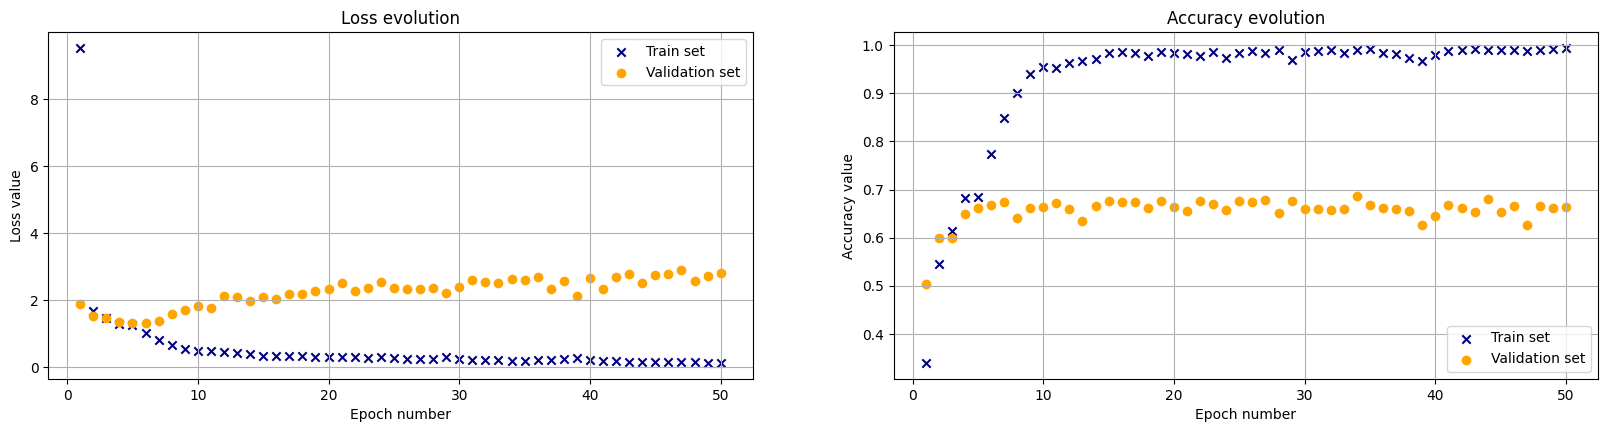

In [52]:
figure = get_plts_from_model(model_h)
figure

Let's try the regularization of the dense layers as well

In [55]:
model = create_compile_default_model(regularization='l2', regularize_fully_connected=True)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 146, 146, 16)      1216      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 73, 73, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 69, 69, 32)        12832     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 34, 34, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 30, 30, 64)        51264     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 15, 15, 64)      

Let's also create a callback function to stop training short if we get a given values of accuracy

In [56]:
class Stopping_Train_Callback(tf.keras.callbacks.Callback):

  def __init__(self, training_threshold = 0.95, validation_threshold = 0.9):
    super().__init__()
    self.training_threshold = training_threshold
    self.validation_threshold = validation_threshold

    self.train_acc_history = []
    self.val_acc_history = []

  def halting_by_plateau(self):
    pass

  def halting_by_threshold(self, t_acc, v_acc):
    if t_acc >= self.training_threshold and v_acc >= self.validation_threshold:
      self.model.stop_training = True
      print('\nThresholds surpased')
      print(f'Current training acc : {round(t_acc, 3)} >= {self.training_threshold}')
      print(f'Current validation acc : {round(v_acc, 3)} >= {self.validation_threshold}')

  def on_epoch_end(self, epoch, logs=None):
    if not isinstance(logs, typing.Dict):
      return
    t_acc = logs.get('accuracy')
    v_acc = logs.get('val_accuracy')
    self.halting_by_threshold(t_acc, v_acc)
    

In [57]:
epoch_callback = Stopping_Train_Callback(0.95, 0.8)
model_h = model.fit(train_dataset, epochs = 50, validation_data=test_dataset, callbacks=[epoch_callback])

Epoch 1/50
110/110 [==============================] - 15s 112ms/step - loss: 9.6062 - accuracy: 0.4485 - val_loss: 5.6874 - val_accuracy: 0.5410
Epoch 2/50
110/110 [==============================] - 12s 108ms/step - loss: 4.9816 - accuracy: 0.6023 - val_loss: 4.4184 - val_accuracy: 0.6273
Epoch 3/50
110/110 [==============================] - 12s 104ms/step - loss: 4.0657 - accuracy: 0.6452 - val_loss: 3.6921 - val_accuracy: 0.6587
Epoch 4/50
110/110 [==============================] - 13s 110ms/step - loss: 3.3643 - accuracy: 0.6994 - val_loss: 3.2317 - val_accuracy: 0.6473
Epoch 5/50
110/110 [==============================] - 13s 119ms/step - loss: 2.9084 - accuracy: 0.7183 - val_loss: 2.9454 - val_accuracy: 0.6443
Epoch 6/50
110/110 [==============================] - 13s 110ms/step - loss: 2.5404 - accuracy: 0.7428 - val_loss: 2.4768 - val_accuracy: 0.7137
Epoch 7/50
110/110 [==============================] - 12s 109ms/step - loss: 2.2344 - accuracy: 0.7677 - val_loss: 2.1471 - val_ac

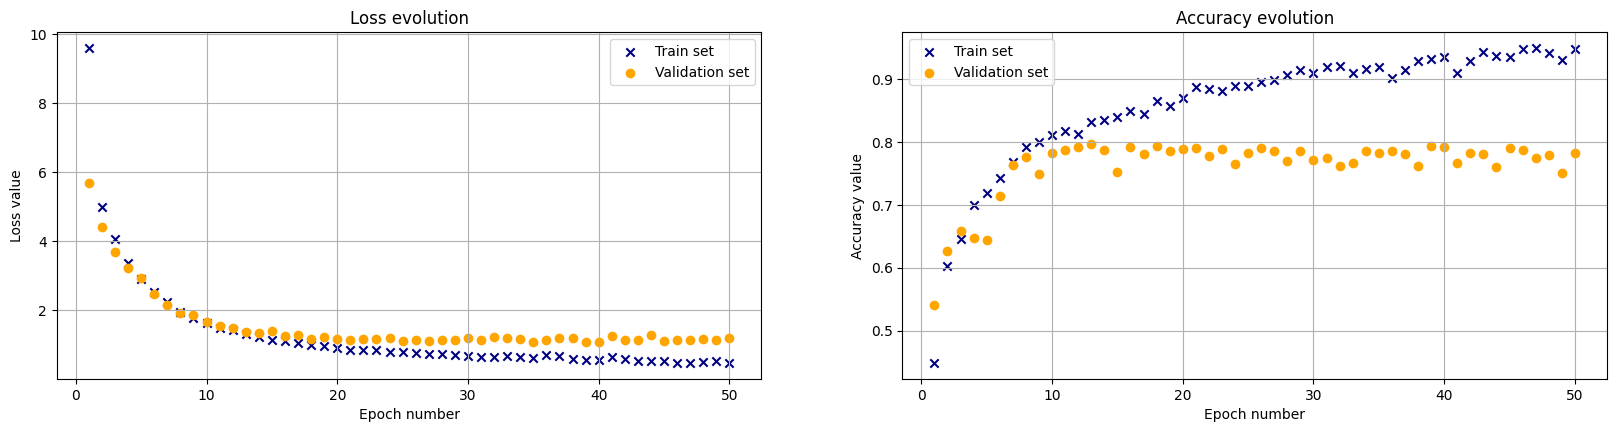

In [58]:
figure2 = get_plts_from_model(model_h)
figure2

Alright, so much better, but still with a problem in the validation from.

The training dataset is creeping upwards slowly, but we still are stucked at the 0.8 limit for the validation dataset.

2. Let's try **Dropout layers** between the Convolutional ones

In [68]:
model = create_compile_default_model(regularization='l2', regularize_fully_connected=True, include_dropout=True,dropout_rate=0.1)
model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 146, 146, 16)      1216      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 73, 73, 16)       0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 73, 73, 16)        0         
                                                                 
 conv2d_28 (Conv2D)          (None, 69, 69, 32)        12832     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 34, 34, 32)       0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 34, 34, 32)       

In [69]:
epoch_callback = Stopping_Train_Callback(0.95, 0.8)
model_h = model.fit(train_dataset, epochs = 50, validation_data=test_dataset, callbacks=[epoch_callback])

Epoch 1/50
110/110 [==============================] - 15s 108ms/step - loss: 11.5437 - accuracy: 0.4151 - val_loss: 6.2741 - val_accuracy: 0.5527
Epoch 2/50
110/110 [==============================] - 12s 105ms/step - loss: 5.6473 - accuracy: 0.5752 - val_loss: 5.1562 - val_accuracy: 0.5980
Epoch 3/50
110/110 [==============================] - 12s 104ms/step - loss: 4.7182 - accuracy: 0.6160 - val_loss: 4.3593 - val_accuracy: 0.6307
Epoch 4/50
110/110 [==============================] - 13s 114ms/step - loss: 4.0802 - accuracy: 0.6384 - val_loss: 3.8749 - val_accuracy: 0.6317
Epoch 5/50
110/110 [==============================] - 11s 95ms/step - loss: 3.5997 - accuracy: 0.6636 - val_loss: 3.4545 - val_accuracy: 0.6267
Epoch 6/50
110/110 [==============================] - 12s 98ms/step - loss: 3.1918 - accuracy: 0.6821 - val_loss: 3.0367 - val_accuracy: 0.6777
Epoch 7/50
110/110 [==============================] - 12s 104ms/step - loss: 2.9062 - accuracy: 0.6939 - val_loss: 2.8678 - val_acc

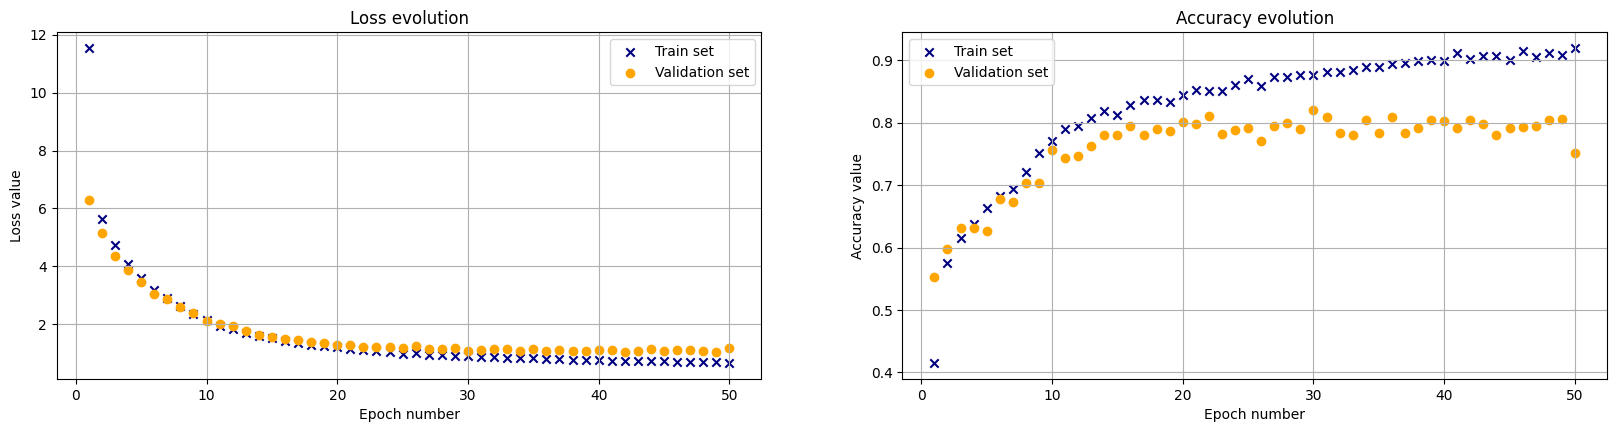

In [70]:
figure3 = get_plts_from_model(model_h)
figure3

Alright, slighty better

Let's increase the dropout rate to see if we can bring even closer the train a validation accuracies...even at the expense of training accuracy overall

In [73]:
model = create_compile_default_model(regularization='l2', regularize_fully_connected=True, include_dropout=True,dropout_rate=0.15)
model.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 146, 146, 16)      1216      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 73, 73, 16)       0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 73, 73, 16)        0         
                                                                 
 conv2d_34 (Conv2D)          (None, 69, 69, 32)        12832     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 34, 34, 32)       0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 34, 34, 32)      

In [74]:
epoch_callback = Stopping_Train_Callback(0.92, 0.90)
model_h = model.fit(train_dataset, epochs = 50, validation_data=test_dataset, callbacks=[epoch_callback])

Epoch 1/50
  6/110 [>.............................] - ETA: 9s - loss: 134.5248 - accuracy: 0.1497 

110/110 [==============================] - 15s 114ms/step - loss: 14.9076 - accuracy: 0.2777 - val_loss: 7.0397 - val_accuracy: 0.4577
Epoch 2/50
110/110 [==============================] - 13s 110ms/step - loss: 6.3419 - accuracy: 0.5018 - val_loss: 5.8120 - val_accuracy: 0.5363
Epoch 3/50
110/110 [==============================] - 13s 112ms/step - loss: 5.4145 - accuracy: 0.5404 - val_loss: 5.0861 - val_accuracy: 0.5650
Epoch 4/50
110/110 [==============================] - 15s 134ms/step - loss: 4.7980 - accuracy: 0.5574 - val_loss: 4.5728 - val_accuracy: 0.5563
Epoch 5/50
110/110 [==============================] - 13s 111ms/step - loss: 4.3042 - accuracy: 0.5917 - val_loss: 4.1278 - val_accuracy: 0.5767
Epoch 6/50
110/110 [==============================] - 13s 113ms/step - loss: 3.9043 - accuracy: 0.6080 - val_loss: 3.7461 - val_accuracy: 0.6193
Epoch 7/50
110/110 [==============================] - 13s 112ms/step - loss: 3.5597 - accuracy: 0.6414 - val_loss: 3.3808 - val_accuracy: 0.

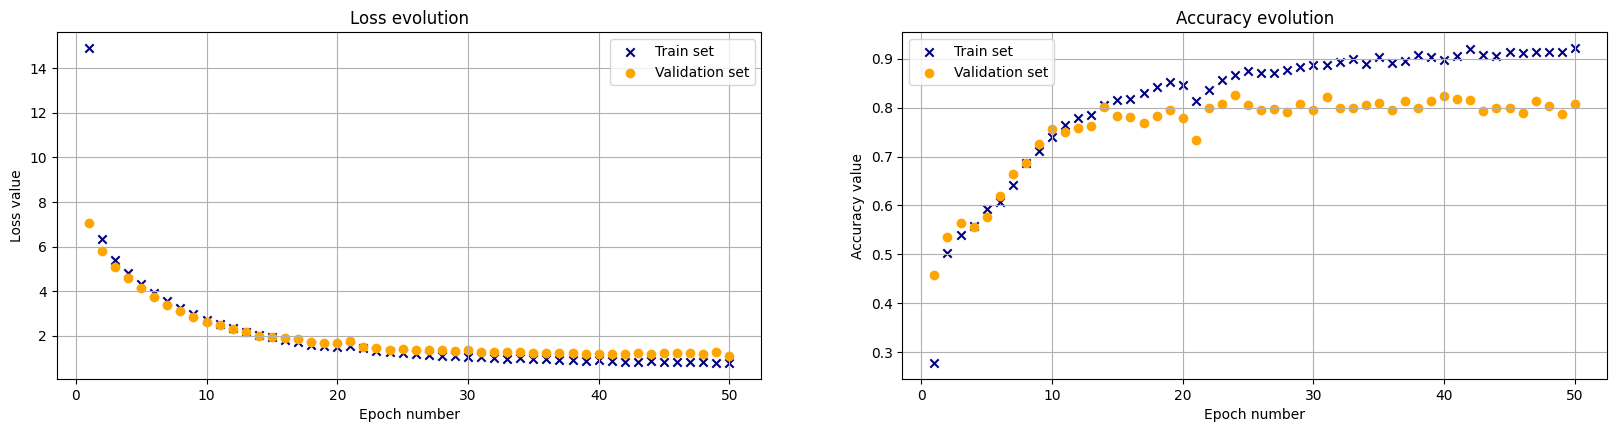

In [75]:
figure4 = get_plts_from_model(model_h)
figure4

Creeping upwards, but not fast enough ... soo, dropout in the fully connected (dense) layers?

In [77]:
model = create_compile_default_model(
    regularization='l2', 
    regularize_fully_connected=True, 
    include_dropout=True,
    dropout_rate=0.15,
    include_FC_dropout=True,
    dropout_FC_rate=0.1
)
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 146, 146, 16)      1216      
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 73, 73, 16)       0         
 g2D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 73, 73, 16)        0         
                                                                 
 conv2d_37 (Conv2D)          (None, 69, 69, 32)        12832     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 34, 34, 32)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 34, 34, 32)      

In [78]:
epoch_callback = Stopping_Train_Callback(0.92, 0.90)
model_h = model.fit(train_dataset, epochs = 50, validation_data=test_dataset, callbacks=[epoch_callback])

Epoch 1/50
110/110 [==============================] - 18s 133ms/step - loss: 11.7339 - accuracy: 0.4396 - val_loss: 6.9422 - val_accuracy: 0.5020
Epoch 2/50
110/110 [==============================] - 14s 122ms/step - loss: 6.1966 - accuracy: 0.5978 - val_loss: 5.6016 - val_accuracy: 0.6480
Epoch 3/50
110/110 [==============================] - 13s 108ms/step - loss: 5.2076 - accuracy: 0.6565 - val_loss: 4.8914 - val_accuracy: 0.6523
Epoch 4/50
110/110 [==============================] - 13s 111ms/step - loss: 4.5027 - accuracy: 0.6934 - val_loss: 4.1950 - val_accuracy: 0.7330
Epoch 5/50
110/110 [==============================] - 13s 112ms/step - loss: 4.0052 - accuracy: 0.7071 - val_loss: 3.7423 - val_accuracy: 0.7287
Epoch 6/50
110/110 [==============================] - 13s 111ms/step - loss: 3.5395 - accuracy: 0.7387 - val_loss: 3.3524 - val_accuracy: 0.7647
Epoch 7/50
110/110 [==============================] - 13s 111ms/step - loss: 3.1753 - accuracy: 0.7575 - val_loss: 3.0266 - val_a

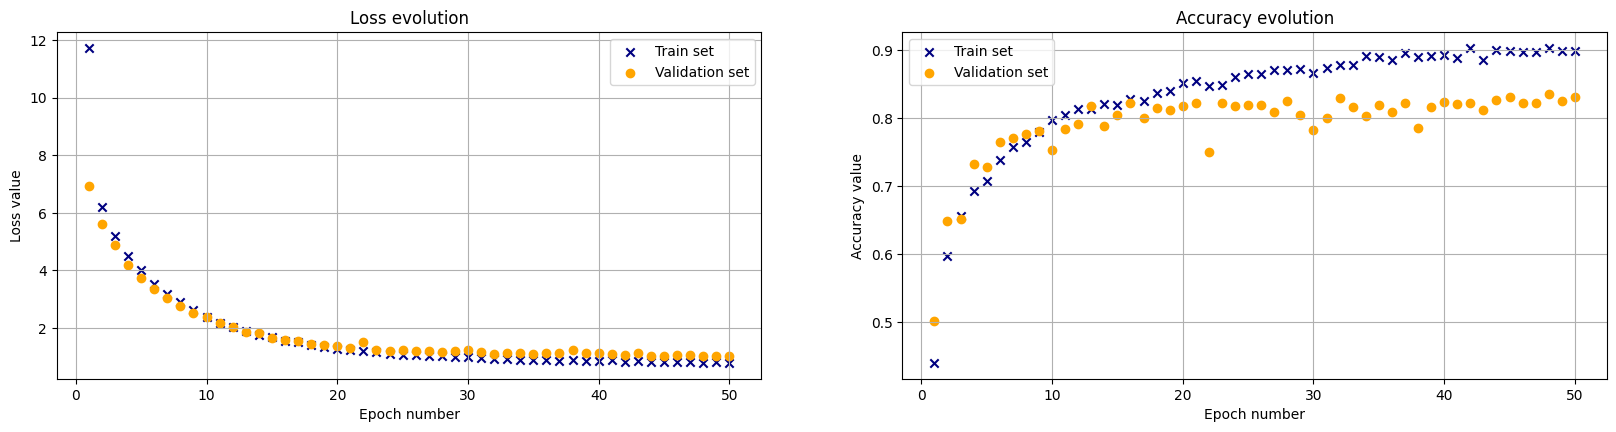

In [79]:
figure5 = get_plts_from_model(model_h)
figure5

Still, moderate improvements ... larger dropout rates could be a way forwards, but most likely would result in worst overall accuracies

We can also try larger convolutional depths (channels) ... to see the effect (although we would already be playing the cards of improving bias ...)

In [80]:
model = create_compile_default_model(
    regularization='l2', 
    regularize_fully_connected=True, 
    include_dropout=True,
    dropout_rate=0.15,
    include_FC_dropout=True,
    dropout_FC_rate=0.15
)
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 146, 146, 16)      1216      
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 73, 73, 16)       0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 73, 73, 16)        0         
                                                                 
 conv2d_40 (Conv2D)          (None, 69, 69, 32)        12832     
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 34, 34, 32)       0         
 g2D)                                                            
                                                                 
 dropout_23 (Dropout)        (None, 34, 34, 32)      

Epoch 1/50
  6/110 [>.............................] - ETA: 9s - loss: 88.2091 - accuracy: 0.1732  

110/110 [==============================] - 15s 112ms/step - loss: 12.4246 - accuracy: 0.2525 - val_loss: 7.1335 - val_accuracy: 0.3850
Epoch 2/50
110/110 [==============================] - 13s 112ms/step - loss: 6.3188 - accuracy: 0.4608 - val_loss: 5.5960 - val_accuracy: 0.5357
Epoch 3/50
110/110 [==============================] - 13s 112ms/step - loss: 5.1644 - accuracy: 0.5284 - val_loss: 4.7795 - val_accuracy: 0.5640
Epoch 4/50
110/110 [==============================] - 13s 113ms/step - loss: 4.4459 - accuracy: 0.5581 - val_loss: 4.1020 - val_accuracy: 0.6093
Epoch 5/50
110/110 [==============================] - 13s 113ms/step - loss: 3.8539 - accuracy: 0.5923 - val_loss: 3.7599 - val_accuracy: 0.5813
Epoch 6/50
110/110 [==============================] - 13s 112ms/step - loss: 3.4261 - accuracy: 0.6168 - val_loss: 3.2769 - val_accuracy: 0.6377
Epoch 7/50
110/110 [==============================] - 12s 110ms/step - loss: 3.0721 - accuracy: 0.6405 - val_loss: 2.9330 - val_accuracy: 0.

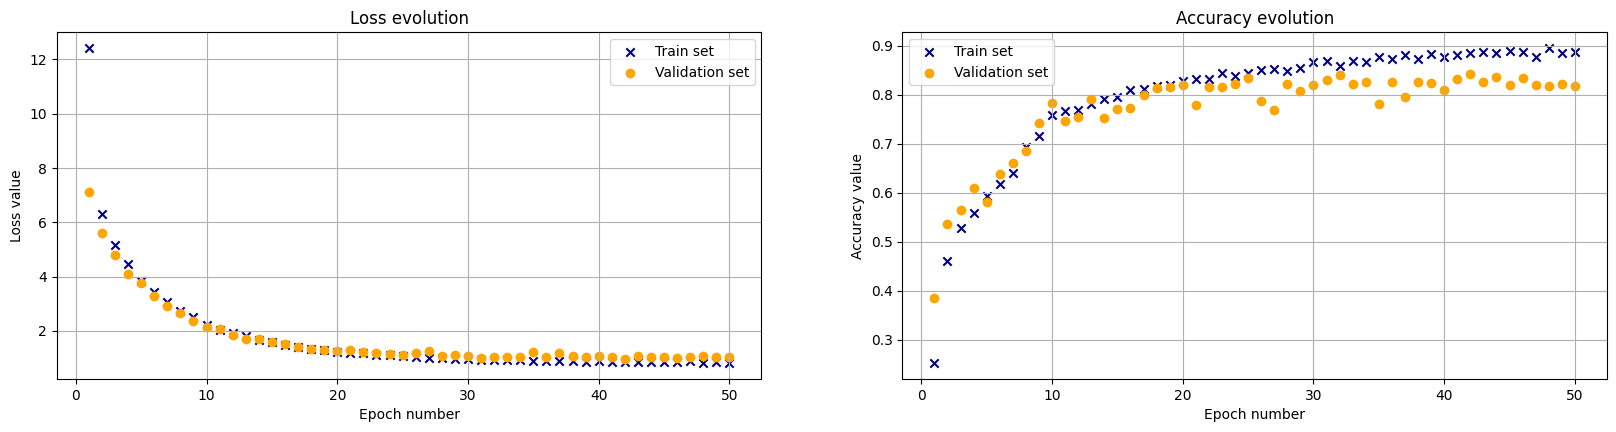

In [81]:
epoch_callback = Stopping_Train_Callback(0.92, 0.90)
model_h = model.fit(train_dataset, epochs = 50, validation_data=test_dataset, callbacks=[epoch_callback])

figure6 = get_plts_from_model(model_h)
figure6

Alright, we are close to converging both accuracy measurements

But, we are doing so at the expense of having a worst training accuracy overall

Let's try a final run with larger dropout values, and then we will begin to work on the model itself

In [84]:
model = create_compile_default_model(
    regularization='l2', 
    regularize_fully_connected=True, 
    include_dropout=True,
    dropout_rate=0.2,
    include_FC_dropout=True,
    dropout_FC_rate=0.2
)
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 146, 146, 16)      1216      
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 73, 73, 16)       0         
 g2D)                                                            
                                                                 
 dropout_29 (Dropout)        (None, 73, 73, 16)        0         
                                                                 
 conv2d_43 (Conv2D)          (None, 69, 69, 32)        12832     
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 34, 34, 32)       0         
 g2D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 34, 34, 32)      

Epoch 1/50
110/110 [==============================] - 16s 114ms/step - loss: 14.9927 - accuracy: 0.3560 - val_loss: 7.3014 - val_accuracy: 0.4733
Epoch 2/50
110/110 [==============================] - 13s 112ms/step - loss: 6.6824 - accuracy: 0.4723 - val_loss: 6.1882 - val_accuracy: 0.4617
Epoch 3/50
110/110 [==============================] - 14s 120ms/step - loss: 5.6669 - accuracy: 0.5024 - val_loss: 5.2770 - val_accuracy: 0.5240
Epoch 4/50
110/110 [==============================] - 13s 112ms/step - loss: 4.9285 - accuracy: 0.5107 - val_loss: 4.6723 - val_accuracy: 0.5100
Epoch 5/50
110/110 [==============================] - 13s 112ms/step - loss: 4.3533 - accuracy: 0.5286 - val_loss: 4.0595 - val_accuracy: 0.5583
Epoch 6/50
110/110 [==============================] - 13s 112ms/step - loss: 3.8991 - accuracy: 0.5461 - val_loss: 3.6690 - val_accuracy: 0.5767
Epoch 7/50
110/110 [==============================] - 13s 109ms/step - loss: 3.5354 - accuracy: 0.5522 - val_loss: 3.3406 - val_a

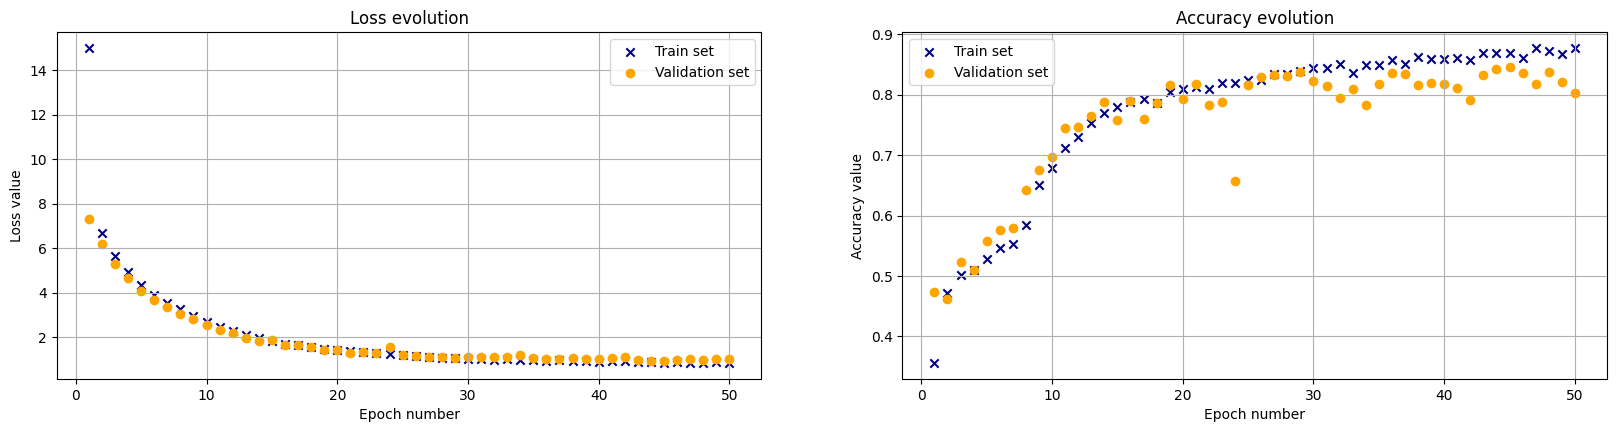

In [85]:
epoch_callback = Stopping_Train_Callback(0.92, 0.90)
model_h = model.fit(train_dataset, epochs = 50, validation_data=test_dataset, callbacks=[epoch_callback])

figure7 = get_plts_from_model(model_h)
figure7

**Awesome, we aremaking progress**

The thing is,maybe not fast enough, so let's try now to introduce some changes into the model.

3. Adding more channels depth to already existing convolutional layers

In [86]:
model = create_compile_default_model(
    channels= [32,64,128],
    regularization='l2', 
    regularize_fully_connected=True, 
    include_dropout=True,
    dropout_rate=0.2,
    include_FC_dropout=True,
    dropout_FC_rate=0.2
)
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 146, 146, 32)      2432      
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 73, 73, 32)       0         
 g2D)                                                            
                                                                 
 dropout_34 (Dropout)        (None, 73, 73, 32)        0         
                                                                 
 conv2d_46 (Conv2D)          (None, 69, 69, 64)        51264     
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 34, 34, 64)       0         
 g2D)                                                            
                                                                 
 dropout_33 (Dropout)        (None, 34, 34, 64)      

Epoch 1/50
  6/110 [>.............................] - ETA: 15s - loss: 84.5907 - accuracy: 0.1562

110/110 [==============================] - 26s 178ms/step - loss: 13.1888 - accuracy: 0.3247 - val_loss: 7.7661 - val_accuracy: 0.4800
Epoch 2/50
110/110 [==============================] - 17s 147ms/step - loss: 6.8299 - accuracy: 0.5067 - val_loss: 6.3775 - val_accuracy: 0.4507
Epoch 3/50
110/110 [==============================] - 18s 158ms/step - loss: 5.4982 - accuracy: 0.5425 - val_loss: 4.9591 - val_accuracy: 0.5793
Epoch 4/50
110/110 [==============================] - 17s 148ms/step - loss: 4.5576 - accuracy: 0.5878 - val_loss: 4.1750 - val_accuracy: 0.6177
Epoch 5/50
110/110 [==============================] - 18s 161ms/step - loss: 3.8277 - accuracy: 0.6436 - val_loss: 3.5095 - val_accuracy: 0.6983
Epoch 6/50
110/110 [==============================] - 17s 150ms/step - loss: 3.3324 - accuracy: 0.6936 - val_loss: 3.0712 - val_accuracy: 0.7457
Epoch 7/50
110/110 [==============================] - 17s 148ms/step - loss: 2.8925 - accuracy: 0.7447 - val_loss: 2.7371 - val_accuracy: 0.

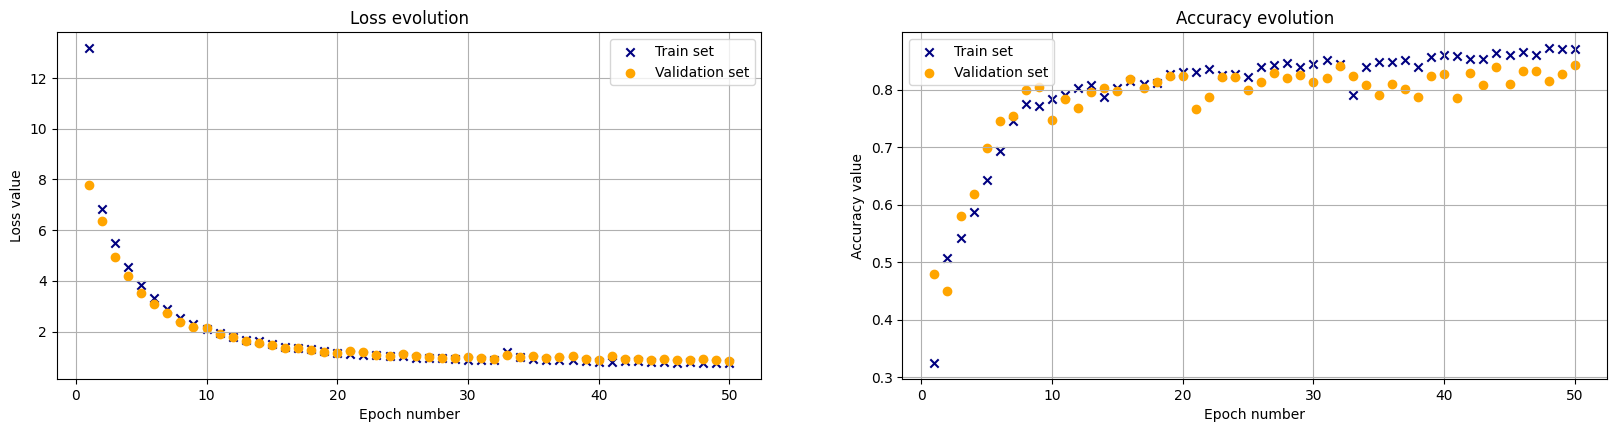

In [87]:
epoch_callback = Stopping_Train_Callback(0.92, 0.90)
model_h = model.fit(train_dataset, epochs = 50, validation_data=test_dataset, callbacks=[epoch_callback])

figure8 = get_plts_from_model(model_h)
figure8

Let's increase depth once again, and drecrease a bit the kernel sizes in the initial layers ...

But to do so I have to create another model creator ... But this time I'm going to do so by a class system

In [ ]:
def create_compile_default_model(
    alpha = 0.001,
    beta1 = 0.9, 
    beta2 = 0.999, 
    regularization = None, 
    regularize_fully_connected : bool = False,
    channels : typing.List | None = None,
    include_dropout : bool = False,
    dropout_rate = 0.2,
    include_FC_dropout : bool = False,
    dropout_FC_rate = 0.2):
  
  reg_dense = None
  if isinstance(channels, typing.List):
    c1, c2, c3 = channels
  else:
    c1, c2, c3 = [16,32,64]

  if regularize_fully_connected:
    reg_dense = 'l2'

  
  layers_config = [
        tf.keras.layers.Conv2D(c1, (5,5), activation = 'relu', input_shape = (150,150,3), kernel_regularizer=regularization),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(c2, (5,5), activation = 'relu', kernel_regularizer=regularization),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(c3, (5,5), activation = 'relu', kernel_regularizer=regularization),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256,activation = 'relu', kernel_regularizer= reg_dense),
        tf.keras.layers.Dense(64,activation = 'relu', kernel_regularizer= reg_dense),
        tf.keras.layers.Dense(6,activation = 'softmax'),
    ]

  if include_FC_dropout:
    for id_position in [9,8]:
      layers_config.insert(id_position, tf.keras.layers.Dropout(rate = dropout_FC_rate))

  if include_dropout:
    # We go in reverese, so the indices still make sense
    for id_position in [6,4,2]:
      layers_config.insert(id_position, tf.keras.layers.Dropout(rate = dropout_rate))
  
  model = tf.keras.Sequential(layers_config)
  model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(learning_rate = alpha, beta_1 = beta1, beta_2 = beta2),
      metrics = ['accuracy']
  )
  return model

In [106]:
class Model_creator:
  def __init__(self, input_shape = (150,150,3)):
    self.input_shape = input_shape
    
    self.recipy_functions = {
        'ConvLayer' : self.add_convolutional_layer,
        'FCLayer' : self.add_FC_layer,
        'OutputLayer' : self.add_output_layer
    }
    self.model_recipy = []
    

  def add_convolutional_layer(self,
                              channels = 16, kernel_size = 5, 
                              maxpool_size = 2, maxpool_stride = 2, 
                              regularization = None, 
                              dropout : bool = False, dropout_rate = 0.2,
                              init_layer : bool = False, lastconv : bool = False):
    
    if init_layer:
      print('Adding init layer')
      convlayer = tf.keras.layers.Conv2D(
          channels, 
          (kernel_size, kernel_size),
          activation = 'relu', input_shape = self.input_shape,
          kernel_regularizer=regularization
      )

    else:
      convlayer = tf.keras.layers.Conv2D(
          channels, 
          (kernel_size, kernel_size),
          activation = 'relu',
          kernel_regularizer=regularization
      )

    conv_layer_config = [
        convlayer,
        tf.keras.layers.MaxPool2D(maxpool_size, maxpool_stride)
    ]

    if dropout:
      conv_layer_config.append(
          tf.keras.layers.Dropout(rate = dropout_rate)
      )

    if lastconv:
      conv_layer_config.append(
          tf.keras.layers.Flatten()
      )
    
    return conv_layer_config

  def add_FC_layer(self, neurons = 512, 
                   regularization = None,
                   dropout : bool = False, dropout_rate = 0.2,):
    fc_layer = [
        tf.keras.layers.Dense(neurons, kernel_regularizer=regularization),
    ]
    if dropout:
      fc_layer.append(tf.keras.layers.Dropout(rate = dropout_rate))
    
    return fc_layer

  def add_output_layer(self, neurons = 6, activation = 'softmax'):
    return [tf.keras.layers.Dense(neurons, activation=activation),]


  def create_model(self, recipy : typing.Dict | None = None):
    if not isinstance(recipy, typing.Dict):
      raise TypeError

    model_config = []
    for key, item in recipy.items():
      item_layer_list = self.recipy_functions.get(item[0])(**item[1])
      model_config.extend(item_layer_list)
    
    return tf.keras.Sequential(model_config)

Now, let's create a recipy for the model and get it from the class above

In [107]:
DEFAULT_RECIPY = {
      'ConvLayer_1' : (
          'ConvLayer',
          dict(
            channels = 32, kernel_size = 5, 
            maxpool_size = 2, maxpool_stride = 2, 
            regularization = 'l2', 
            dropout = True, dropout_rate = 0.2,
            init_layer = True, lastconv = False
          )
      ),
      'ConvLayer2' : (
          'ConvLayer',
          dict(
            channels = 64, kernel_size = 3, 
            maxpool_size = 2, maxpool_stride = 2, 
            regularization = 'l2', 
            dropout = True, dropout_rate = 0.2,
            init_layer = False, lastconv = False
          )
      ),
      'ConvLayer3' : (
          'ConvLayer',
          dict(
            channels = 64, kernel_size = 3, 
            maxpool_size = 2, maxpool_stride = 2, 
            regularization = 'l2', 
            dropout = True, dropout_rate = 0.2,
            init_layer = False, lastconv = True
          )
      ),
      'FCLayer1' : (  
          'FCLayer',
          dict(
            neurons = 256, 
            regularization = 'l2',
            dropout = True, dropout_rate = 0.2,
          )  
      ),
      'FCLayer2' : (  
          'FCLayer',
          dict(
            neurons = 64, 
            regularization = 'l2',
            dropout = True, dropout_rate = 0.2,
          )  
      ),
      'OutputLayer' : (
        'OutputLayer',
        dict(
            neurons = 6, 
        ) 
      )
}

model_creator = Model_creator()

model = model_creator.create_model(DEFAULT_RECIPY)

Adding init layer


In [108]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 146, 146, 32)      2432      
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 73, 73, 32)       0         
 g2D)                                                            
                                                                 
 dropout_45 (Dropout)        (None, 73, 73, 32)        0         
                                                                 
 conv2d_55 (Conv2D)          (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 35, 35, 64)       0         
 g2D)                                                            
                                                                 
 dropout_46 (Dropout)        (None, 35, 35, 64)      

Epoch 1/50
  6/110 [>.............................] - ETA: 13s - loss: 920.9062 - accuracy: 0.1536 

110/110 [==============================] - 23s 174ms/step - loss: 60.0811 - accuracy: 0.1809 - val_loss: 9.0589 - val_accuracy: 0.1853
Epoch 2/50
110/110 [==============================] - 17s 151ms/step - loss: 8.7179 - accuracy: 0.1846 - val_loss: 8.3807 - val_accuracy: 0.1930
Epoch 3/50
110/110 [==============================] - 19s 165ms/step - loss: 8.0934 - accuracy: 0.2251 - val_loss: 7.8154 - val_accuracy: 0.2077
Epoch 4/50
110/110 [==============================] - 15s 134ms/step - loss: 7.5614 - accuracy: 0.2421 - val_loss: 7.3496 - val_accuracy: 0.1963
Epoch 5/50
110/110 [==============================] - 15s 135ms/step - loss: 6.9493 - accuracy: 0.3383 - val_loss: 7.0409 - val_accuracy: 0.1920
Epoch 6/50
110/110 [==============================] - 15s 133ms/step - loss: 6.4763 - accuracy: 0.3898 - val_loss: 6.4149 - val_accuracy: 0.2987
Epoch 7/50
110/110 [==============================] - 15s 135ms/step - loss: 6.0392 - accuracy: 0.4222 - val_loss: 5.6718 - val_accuracy: 0.

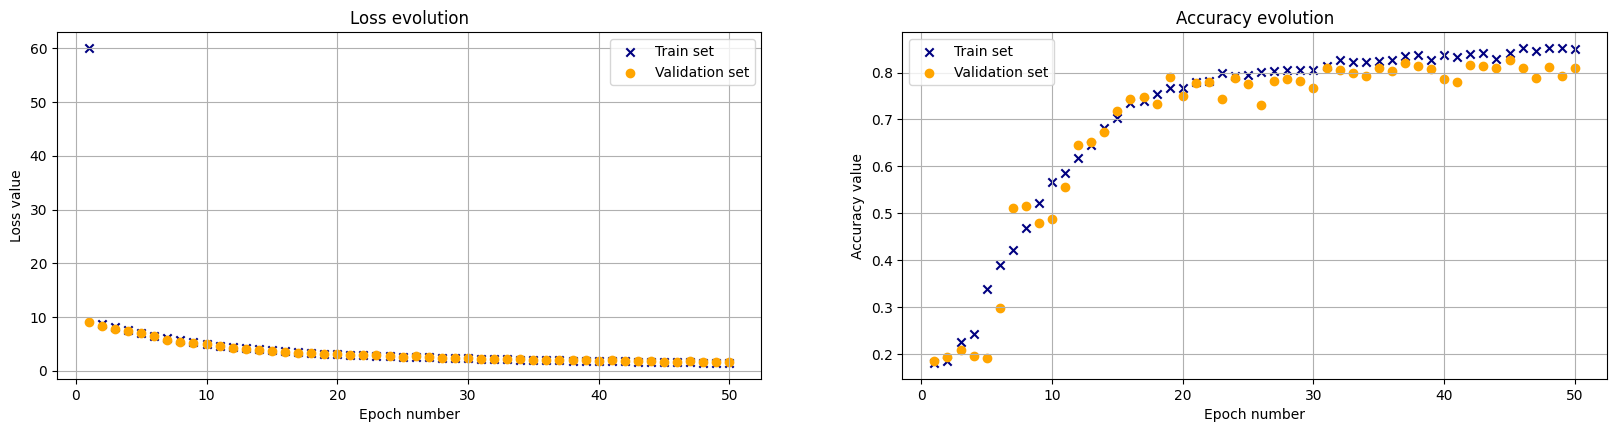

In [109]:
model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics = ['accuracy']
)

epoch_callback = Stopping_Train_Callback(0.92, 0.90)
model_h = model.fit(train_dataset, epochs = 50, validation_data=test_dataset, callbacks=[epoch_callback])

figure9 = get_plts_from_model(model_h)
figure9

Let's tweak a little bit the model 

In [110]:
RECIPY_0 = {
      'ConvLayer_1' : (
          'ConvLayer',
          dict(
            channels = 32, kernel_size = 5, 
            maxpool_size = 2, maxpool_stride = 2, 
            regularization = 'l2', 
            dropout = True, dropout_rate = 0.15,
            init_layer = True, lastconv = False
          )
      ),
      'ConvLayer2' : (
          'ConvLayer',
          dict(
            channels = 64, kernel_size = 3, 
            maxpool_size = 2, maxpool_stride = 2, 
            regularization = 'l2', 
            dropout = True, dropout_rate = 0.15,
            init_layer = False, lastconv = False
          )
      ),
      'ConvLayer3' : (
          'ConvLayer',
          dict(
            channels = 64, kernel_size = 3, 
            maxpool_size = 2, maxpool_stride = 2, 
            regularization = 'l2', 
            dropout = True, dropout_rate = 0.15,
            init_layer = False, lastconv = True
          )
      ),
      'FCLayer1' : (  
          'FCLayer',
          dict(
            neurons = 512, 
            regularization = 'l2',
            dropout = True, dropout_rate = 0.2,
          )  
      ),
      'FCLayer2' : (  
          'FCLayer',
          dict(
            neurons = 128, 
            regularization = 'l2',
            dropout = True, dropout_rate = 0.2,
          )  
      ),
      'FCLayer2' : (  
          'FCLayer',
          dict(
            neurons = 32, 
            regularization = 'l2',
            dropout = True, dropout_rate = 0.2,
          )  
      ),
      'OutputLayer' : (
        'OutputLayer',
        dict(
            neurons = 6, 
        ) 
      )
}

model_creator = Model_creator()

model = model_creator.create_model(RECIPY_0)

Adding init layer


Epoch 1/50
  6/110 [>.............................] - ETA: 15s - loss: 2096.8301 - accuracy: 0.1628

110/110 [==============================] - 20s 144ms/step - loss: 130.8611 - accuracy: 0.2059 - val_loss: 13.6030 - val_accuracy: 0.1877
Epoch 2/50
110/110 [==============================] - 15s 136ms/step - loss: 13.0238 - accuracy: 0.2802 - val_loss: 12.5774 - val_accuracy: 0.2293
Epoch 3/50
110/110 [==============================] - 16s 139ms/step - loss: 12.0173 - accuracy: 0.3442 - val_loss: 11.8517 - val_accuracy: 0.2013
Epoch 4/50
110/110 [==============================] - 17s 150ms/step - loss: 11.1775 - accuracy: 0.3800 - val_loss: 11.2128 - val_accuracy: 0.2050
Epoch 5/50
110/110 [==============================] - 16s 140ms/step - loss: 10.4579 - accuracy: 0.3937 - val_loss: 10.5030 - val_accuracy: 0.2193
Epoch 6/50
110/110 [==============================] - 15s 136ms/step - loss: 9.8141 - accuracy: 0.4074 - val_loss: 10.0067 - val_accuracy: 0.2217
Epoch 7/50
110/110 [==============================] - 16s 138ms/step - loss: 9.2384 - accuracy: 0.4166 - val_loss: 9.3982 - val_a

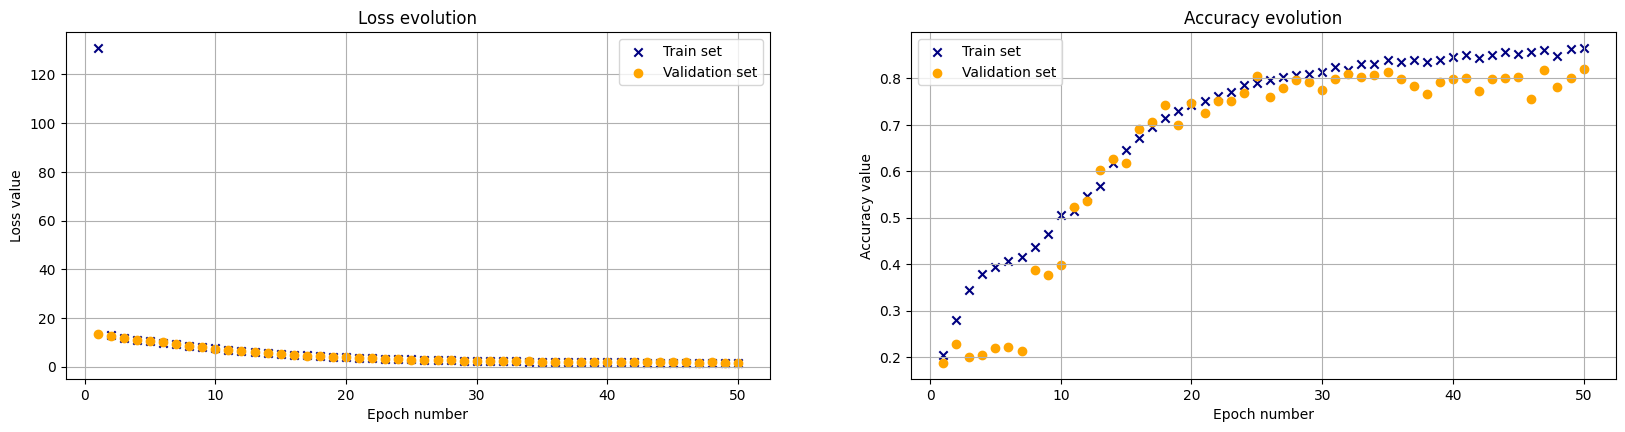

In [111]:
model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics = ['accuracy']
)

epoch_callback = Stopping_Train_Callback(0.92, 0.90)
model_h = model.fit(train_dataset, epochs = 50, validation_data=test_dataset, callbacks=[epoch_callback])

figure10 = get_plts_from_model(model_h)
figure10

Finally, we can create a callback for the learning rate, to decrease it's value towards the total number of epochs, and train for longer, as we haven't reached the pleateau still ...